In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass_v2\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped_v2/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped_v2/Test"

cuda


# Import Data

In [5]:

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, model):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.model_fe = nn.Sequential(*list(model.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=9216, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.model_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(model = models.alexnet(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 2506564


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


train loss:  0.12022041412686471
Val loss:  0.11926312239273734
train accuracy:  0.5841392649903289
Val accuracy:  0.5739130434782609
Best model at the moment with Val_acc 57.39, saving...
Current time: 6.523 minutes. Time expected till completion: 645.765 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:01<00:00, 14.94it/s]


train loss:  0.1069602085208985
Val loss:  0.12401606233223625
train accuracy:  0.6237911025145068
Val accuracy:  0.6260869565217392
Best model at the moment with Val_acc 62.61, saving...
Current time: 6.861 minutes. Time expected till completion: 336.177 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.09831077650160577
Val loss:  0.12254926717799643
train accuracy:  0.6653771760154739
Val accuracy:  0.5478260869565217
Current time: 7.135 minutes. Time expected till completion: 230.687 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:01<00:00, 13.54it/s]


train loss:  0.09443916541810654
Val loss:  0.13187539421993752
train accuracy:  0.6740812379110251
Val accuracy:  0.5304347826086957
Current time: 7.417 minutes. Time expected till completion: 178.010 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:01<00:00, 14.66it/s]


train loss:  0.08784707311389525
Val loss:  0.11184573329013327
train accuracy:  0.688588007736944
Val accuracy:  0.591304347826087
Current time: 7.695 minutes. Time expected till completion: 146.209 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:01<00:00, 14.24it/s]


train loss:  0.0825387336587537
Val loss:  0.1084974441839301
train accuracy:  0.7176015473887815
Val accuracy:  0.6086956521739131
Current time: 7.976 minutes. Time expected till completion: 124.960 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:01<00:00, 14.06it/s]


train loss:  0.07721924572837191
Val loss:  0.11817150349202363
train accuracy:  0.7456479690522244
Val accuracy:  0.6086956521739131
Current time: 8.263 minutes. Time expected till completion: 109.776 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:01<00:00, 14.46it/s]


train loss:  0.0736745582097273
Val loss:  0.12111629778924196
train accuracy:  0.769825918762089
Val accuracy:  0.6086956521739131
Current time: 8.551 minutes. Time expected till completion: 98.334 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:01<00:00, 14.53it/s]


train loss:  0.06951059364286798
Val loss:  0.12008917409440746
train accuracy:  0.7775628626692457
Val accuracy:  0.5826086956521739
Current time: 8.824 minutes. Time expected till completion: 89.224 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:00<00:00, 15.09it/s]


train loss:  0.06570747948649773
Val loss:  0.13414206232713616
train accuracy:  0.7998065764023211
Val accuracy:  0.5478260869565217
Current time: 9.098 minutes. Time expected till completion: 81.886 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:01<00:00, 14.43it/s]


train loss:  0.06100924021241974
Val loss:  0.12435975735602171
train accuracy:  0.793036750483559
Val accuracy:  0.591304347826087
Current time: 9.374 minutes. Time expected till completion: 75.840 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:00<00:00, 15.39it/s]


train loss:  0.05537968936666299
Val loss:  0.16154552335324496
train accuracy:  0.8413926499032882
Val accuracy:  0.5304347826086957
Current time: 9.643 minutes. Time expected till completion: 70.714 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:01<00:00, 14.86it/s]


train loss:  0.05254845723970946
Val loss:  0.12855080897393434
train accuracy:  0.8317214700193424
Val accuracy:  0.6347826086956522
Best model at the moment with Val_acc 63.48, saving...
Current time: 9.915 minutes. Time expected till completion: 66.351 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:01<00:00, 14.62it/s]


train loss:  0.0509940443967597
Val loss:  0.16352557514024818
train accuracy:  0.8558994197292069
Val accuracy:  0.5478260869565217
Current time: 10.185 minutes. Time expected till completion: 62.567 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:01<00:00, 13.95it/s]


train loss:  0.04768154755004139
Val loss:  0.18722106762554336
train accuracy:  0.8626692456479691
Val accuracy:  0.5043478260869565
Current time: 10.464 minutes. Time expected till completion: 59.296 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


train loss:  0.04504831037276949
Val loss:  0.13416609193967735
train accuracy:  0.8665377176015474
Val accuracy:  0.6260869565217392
Current time: 10.744 minutes. Time expected till completion: 56.404 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:01<00:00, 14.60it/s]


train loss:  0.04041387044195972
Val loss:  0.1369976493327514
train accuracy:  0.8858800773694391
Val accuracy:  0.6173913043478261
Current time: 11.016 minutes. Time expected till completion: 53.783 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:01<00:00, 13.85it/s]


train loss:  0.03761595015988705
Val loss:  0.15706113188163093
train accuracy:  0.9003868471953579
Val accuracy:  0.5739130434782609
Current time: 11.286 minutes. Time expected till completion: 51.413 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:01<00:00, 14.26it/s]


train loss:  0.0362420544312903
Val loss:  0.14368095268373904
train accuracy:  0.8965183752417795
Val accuracy:  0.5826086956521739
Current time: 11.571 minutes. Time expected till completion: 49.330 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:01<00:00, 12.30it/s]


train loss:  0.03164604789535992
Val loss:  0.1545384811318439
train accuracy:  0.9177949709864603
Val accuracy:  0.6086956521739131
Current time: 11.882 minutes. Time expected till completion: 47.526 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:01<00:00, 11.22it/s]


train loss:  0.02798217833690648
Val loss:  0.15349592825640804
train accuracy:  0.9226305609284333
Val accuracy:  0.6260869565217392
Current time: 12.167 minutes. Time expected till completion: 45.771 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:01<00:00, 14.45it/s]


train loss:  0.027449528187715108
Val loss:  0.16490181101405102
train accuracy:  0.925531914893617
Val accuracy:  0.591304347826087
Current time: 12.442 minutes. Time expected till completion: 44.112 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:01<00:00, 14.55it/s]


train loss:  0.026325203608036963
Val loss:  0.1643405153699543
train accuracy:  0.9274661508704062
Val accuracy:  0.591304347826087
Current time: 12.725 minutes. Time expected till completion: 42.603 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:01<00:00, 14.20it/s]


train loss:  0.02326786997448833
Val loss:  0.16759021878242492
train accuracy:  0.9390715667311412
Val accuracy:  0.6173913043478261
Current time: 13.002 minutes. Time expected till completion: 41.174 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:00<00:00, 15.04it/s]


train loss:  0.022206577616500554
Val loss:  0.1730251765769461
train accuracy:  0.941972920696325
Val accuracy:  0.6173913043478261
Current time: 13.279 minutes. Time expected till completion: 39.838 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:01<00:00, 14.92it/s]


train loss:  0.02041094002585923
Val loss:  0.1673628137163494
train accuracy:  0.9545454545454546
Val accuracy:  0.591304347826087
Current time: 13.556 minutes. Time expected till completion: 38.583 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:01<00:00, 14.45it/s]


train loss:  0.019216760095457475
Val loss:  0.16140531016432721
train accuracy:  0.9477756286266924
Val accuracy:  0.6
Current time: 13.836 minutes. Time expected till completion: 37.409 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:00<00:00, 15.03it/s]


train loss:  0.01627115372341393
Val loss:  0.20666158691696498
train accuracy:  0.9593810444874274
Val accuracy:  0.5652173913043478
Current time: 14.110 minutes. Time expected till completion: 36.283 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:01<00:00, 14.70it/s]


train loss:  0.01627515742354405
Val loss:  0.1793252899594929
train accuracy:  0.9671179883945842
Val accuracy:  0.6434782608695652
Best model at the moment with Val_acc 64.35, saving...
Current time: 14.389 minutes. Time expected till completion: 35.229 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:01<00:00, 14.49it/s]


train loss:  0.013368824617558913
Val loss:  0.1820549981749576
train accuracy:  0.9738878143133463
Val accuracy:  0.6
Current time: 14.666 minutes. Time expected till completion: 34.221 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:01<00:00, 14.30it/s]


train loss:  0.012375951929034113
Val loss:  0.19819862965656362
train accuracy:  0.9738878143133463
Val accuracy:  0.6173913043478261
Current time: 14.942 minutes. Time expected till completion: 33.259 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:01<00:00, 14.12it/s]


train loss:  0.011476029429361368
Val loss:  0.18432199605133223
train accuracy:  0.9806576402321083
Val accuracy:  0.6521739130434783
Best model at the moment with Val_acc 65.22, saving...
Current time: 15.223 minutes. Time expected till completion: 32.348 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:01<00:00, 14.04it/s]


train loss:  0.01041034552279042
Val loss:  0.20967168950516243
train accuracy:  0.9777562862669246
Val accuracy:  0.6260869565217392
Current time: 15.502 minutes. Time expected till completion: 31.474 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:01<00:00, 12.43it/s]


train loss:  0.011531885856099613
Val loss:  0.27793263028497284
train accuracy:  0.9748549323017408
Val accuracy:  0.6173913043478261
Current time: 15.790 minutes. Time expected till completion: 30.650 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


train loss:  0.01136588668621846
Val loss:  0.23527877210922862
train accuracy:  0.9777562862669246
Val accuracy:  0.5826086956521739
Current time: 16.085 minutes. Time expected till completion: 29.873 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  0.007615951130822358
Val loss:  0.1943508540806563
train accuracy:  0.988394584139265
Val accuracy:  0.6434782608695652
Current time: 16.383 minutes. Time expected till completion: 29.126 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:01<00:00, 13.58it/s]


train loss:  0.007070980199258703
Val loss:  0.23403497208719667
train accuracy:  0.988394584139265
Val accuracy:  0.6260869565217392
Current time: 16.659 minutes. Time expected till completion: 28.365 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:01<00:00, 13.87it/s]


train loss:  0.010601929009295784
Val loss:  0.22063775522553403
train accuracy:  0.9835589941972921
Val accuracy:  0.6260869565217392
Current time: 16.942 minutes. Time expected till completion: 27.643 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:01<00:00, 13.21it/s]


train loss:  0.007616243050348129
Val loss:  0.21522610083870267
train accuracy:  0.988394584139265
Val accuracy:  0.6521739130434783
Current time: 17.230 minutes. Time expected till completion: 26.950 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:01<00:00, 14.67it/s]


train loss:  0.005045196358961138
Val loss:  0.22676501986773118
train accuracy:  0.9941972920696325
Val accuracy:  0.6608695652173913
Best model at the moment with Val_acc 66.09, saving...
Current time: 17.515 minutes. Time expected till completion: 26.272 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:01<00:00, 14.02it/s]


train loss:  0.005097363809888329
Val loss:  0.24017515629529954
train accuracy:  0.9932301740812379
Val accuracy:  0.5826086956521739
Current time: 17.796 minutes. Time expected till completion: 25.609 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.006144623447912029
Val loss:  0.23721925849499909
train accuracy:  0.9941972920696325
Val accuracy:  0.6173913043478261
Current time: 18.103 minutes. Time expected till completion: 24.999 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.007181622436075567
Val loss:  0.33575129586717356
train accuracy:  0.9922630560928434
Val accuracy:  0.5217391304347826
Current time: 18.399 minutes. Time expected till completion: 24.390 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:01<00:00, 14.62it/s]


train loss:  0.012398948147172392
Val loss:  0.22540960558082745
train accuracy:  0.97678916827853
Val accuracy:  0.6347826086956522
Current time: 18.693 minutes. Time expected till completion: 23.791 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:01<00:00, 14.93it/s]


train loss:  0.003964055254409176
Val loss:  0.2338196077424547
train accuracy:  0.9980657640232108
Val accuracy:  0.6695652173913044
Best model at the moment with Val_acc 66.96, saving...
Current time: 18.985 minutes. Time expected till completion: 23.204 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


train loss:  0.007425610184790188
Val loss:  0.219411745019581
train accuracy:  0.9874274661508704
Val accuracy:  0.6260869565217392
Current time: 19.291 minutes. Time expected till completion: 22.646 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:01<00:00, 11.49it/s]


train loss:  0.0034237719996385563
Val loss:  0.24210875008417213
train accuracy:  0.9970986460348162
Val accuracy:  0.6173913043478261
Current time: 19.608 minutes. Time expected till completion: 22.111 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:01<00:00, 13.12it/s]


train loss:  0.004276487835916209
Val loss:  0.23151323367720064
train accuracy:  0.9970986460348162
Val accuracy:  0.6347826086956522
Current time: 19.902 minutes. Time expected till completion: 21.560 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:01<00:00, 14.76it/s]


train loss:  0.0033307779828947565
Val loss:  0.24320017666272495
train accuracy:  0.9980657640232108
Val accuracy:  0.6347826086956522
Current time: 20.194 minutes. Time expected till completion: 21.018 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:01<00:00, 12.24it/s]


train loss:  0.004147501336433159
Val loss:  0.25316643455754156
train accuracy:  0.9961315280464217
Val accuracy:  0.6086956521739131
Current time: 20.477 minutes. Time expected till completion: 20.477 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:01<00:00, 13.09it/s]


train loss:  0.0040716234494605945
Val loss:  0.23848624520975611
train accuracy:  0.9961315280464217
Val accuracy:  0.6608695652173913
Current time: 20.781 minutes. Time expected till completion: 19.966 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:01<00:00, 14.32it/s]


train loss:  0.0041974132919523725
Val loss:  0.24523367972477622
train accuracy:  0.9941972920696325
Val accuracy:  0.6608695652173913
Current time: 21.071 minutes. Time expected till completion: 19.450 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:01<00:00, 14.23it/s]


train loss:  0.00684285407806929
Val loss:  0.2520461167978204
train accuracy:  0.9874274661508704
Val accuracy:  0.6
Current time: 21.363 minutes. Time expected till completion: 18.945 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:01<00:00, 14.26it/s]


train loss:  0.003297542478149303
Val loss:  0.2679480623939763
train accuracy:  0.9970986460348162
Val accuracy:  0.6086956521739131
Current time: 21.667 minutes. Time expected till completion: 18.457 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:01<00:00, 12.40it/s]


train loss:  0.004114111982985369
Val loss:  0.2541828504075175
train accuracy:  0.9922630560928434
Val accuracy:  0.6173913043478261
Current time: 21.974 minutes. Time expected till completion: 17.979 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.003186757509969648
Val loss:  0.23940468547136887
train accuracy:  0.9970986460348162
Val accuracy:  0.6521739130434783
Current time: 22.259 minutes. Time expected till completion: 17.489 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:01<00:00, 13.58it/s]


train loss:  0.0032634575544686255
Val loss:  0.26881048472031305
train accuracy:  0.995164410058027
Val accuracy:  0.6521739130434783
Current time: 22.548 minutes. Time expected till completion: 17.010 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:01<00:00, 14.92it/s]


train loss:  0.009422051520788245
Val loss:  0.22640637185262596
train accuracy:  0.9816247582205029
Val accuracy:  0.6173913043478261
Current time: 22.830 minutes. Time expected till completion: 16.532 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:01<00:00, 12.04it/s]


train loss:  0.003772270323517705
Val loss:  0.23120244262011155
train accuracy:  0.995164410058027
Val accuracy:  0.6347826086956522
Current time: 23.116 minutes. Time expected till completion: 16.064 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:01<00:00, 14.56it/s]


train loss:  0.001915315566983027
Val loss:  0.24840310501015705
train accuracy:  0.9980657640232108
Val accuracy:  0.6173913043478261
Current time: 23.414 minutes. Time expected till completion: 15.609 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:01<00:00, 13.88it/s]


train loss:  0.002846271417122172
Val loss:  0.2583184151545815
train accuracy:  0.9970986460348162
Val accuracy:  0.5826086956521739
Current time: 23.691 minutes. Time expected till completion: 15.147 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


train loss:  0.001963275176532858
Val loss:  0.2491344400074171
train accuracy:  0.9990328820116054
Val accuracy:  0.6347826086956522
Current time: 23.982 minutes. Time expected till completion: 14.699 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:01<00:00, 10.57it/s]


train loss:  0.0026653889244997865
Val loss:  0.2633114148741183
train accuracy:  0.9970986460348162
Val accuracy:  0.6434782608695652
Current time: 24.270 minutes. Time expected till completion: 14.254 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:01<00:00, 14.45it/s]


train loss:  0.0024085882050536907
Val loss:  0.24383972559286202
train accuracy:  0.9980657640232108
Val accuracy:  0.6434782608695652
Current time: 24.564 minutes. Time expected till completion: 13.817 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:01<00:00, 14.89it/s]


train loss:  0.0018233091055377966
Val loss:  0.24527790164170057
train accuracy:  0.9980657640232108
Val accuracy:  0.6347826086956522
Current time: 24.844 minutes. Time expected till completion: 13.377 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:01<00:00, 10.99it/s]


train loss:  0.0022965544106067666
Val loss:  0.2564104936045149
train accuracy:  0.9970986460348162
Val accuracy:  0.6608695652173913
Current time: 25.158 minutes. Time expected till completion: 12.960 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:02<00:00,  7.02it/s]


train loss:  0.0013661400475631588
Val loss:  0.25429186199022374
train accuracy:  0.9990328820116054
Val accuracy:  0.6521739130434783
Current time: 25.501 minutes. Time expected till completion: 12.560 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:01<00:00, 13.50it/s]


train loss:  0.007352448250275156
Val loss:  0.2477893653123275
train accuracy:  0.9825918762088974
Val accuracy:  0.6260869565217392
Current time: 25.813 minutes. Time expected till completion: 12.147 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:01<00:00, 13.34it/s]


train loss:  0.0022921257679250698
Val loss:  0.2472905278853748
train accuracy:  0.9970986460348162
Val accuracy:  0.6608695652173913
Current time: 26.111 minutes. Time expected till completion: 11.731 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:01<00:00, 10.89it/s]


train loss:  0.001476732585648961
Val loss:  0.25876354912052985
train accuracy:  0.9990328820116054
Val accuracy:  0.6434782608695652
Current time: 26.418 minutes. Time expected till completion: 11.322 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:01<00:00, 14.65it/s]


train loss:  0.0015631845635864108
Val loss:  0.2687026290142018
train accuracy:  0.9990328820116054
Val accuracy:  0.6086956521739131
Current time: 26.703 minutes. Time expected till completion: 10.907 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:01<00:00, 14.74it/s]


train loss:  0.0014375631462280932
Val loss:  0.263339327664479
train accuracy:  0.9990328820116054
Val accuracy:  0.6608695652173913
Current time: 26.988 minutes. Time expected till completion: 10.495 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:01<00:00, 14.88it/s]


train loss:  0.0023574677080772113
Val loss:  0.28542719159437263
train accuracy:  0.9970986460348162
Val accuracy:  0.591304347826087
Current time: 27.258 minutes. Time expected till completion: 10.082 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:01<00:00, 14.66it/s]


train loss:  0.0014292820973004976
Val loss:  0.268885226936444
train accuracy:  0.9990328820116054
Val accuracy:  0.6260869565217392
Current time: 27.536 minutes. Time expected till completion: 9.675 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:01<00:00, 14.97it/s]


train loss:  0.002516261018735309
Val loss:  0.25704685397770094
train accuracy:  0.9980657640232108
Val accuracy:  0.6782608695652174
Best model at the moment with Val_acc 67.83, saving...
Current time: 27.808 minutes. Time expected till completion: 9.269 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:01<00:00, 10.48it/s]


train loss:  0.0011489146922280871
Val loss:  0.2534791604332302
train accuracy:  0.9990328820116054
Val accuracy:  0.6434782608695652
Current time: 28.097 minutes. Time expected till completion: 8.873 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.0012469524135139845
Val loss:  0.26475620490053425
train accuracy:  0.9990328820116054
Val accuracy:  0.6782608695652174
Current time: 28.398 minutes. Time expected till completion: 8.482 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:01<00:00, 10.84it/s]


train loss:  0.0011678903400067085
Val loss:  0.26233462046669875
train accuracy:  0.9990328820116054
Val accuracy:  0.6695652173913044
Current time: 28.695 minutes. Time expected till completion: 8.093 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.0018255104171005221
Val loss:  0.26831310313680895
train accuracy:  0.9980657640232108
Val accuracy:  0.6521739130434783
Current time: 29.002 minutes. Time expected till completion: 7.709 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  0.0018010101924627628
Val loss:  0.2586682696705279
train accuracy:  0.9980657640232108
Val accuracy:  0.6608695652173913
Current time: 29.308 minutes. Time expected till completion: 7.327 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:01<00:00, 14.28it/s]


train loss:  0.00337850318101822
Val loss:  0.26555057906586194
train accuracy:  0.9932301740812379
Val accuracy:  0.6434782608695652
Current time: 29.612 minutes. Time expected till completion: 6.946 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:01<00:00, 10.92it/s]


train loss:  0.0019797015637473465
Val loss:  0.2709356283364089
train accuracy:  0.9970986460348162
Val accuracy:  0.6173913043478261
Current time: 29.905 minutes. Time expected till completion: 6.565 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:01<00:00, 13.99it/s]


train loss:  0.001007406906819333
Val loss:  0.33137771033722424
train accuracy:  0.9990328820116054
Val accuracy:  0.6173913043478261
Current time: 30.210 minutes. Time expected till completion: 6.188 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:01<00:00, 10.90it/s]


train loss:  0.0021285233105992406
Val loss:  0.2647167049024416
train accuracy:  0.9980657640232108
Val accuracy:  0.6434782608695652
Current time: 30.513 minutes. Time expected till completion: 5.812 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:01<00:00, 13.73it/s]


train loss:  0.0011962742982788023
Val loss:  0.3000690790622131
train accuracy:  0.9990328820116054
Val accuracy:  0.6260869565217392
Current time: 30.798 minutes. Time expected till completion: 5.435 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


train loss:  0.003244923559533309
Val loss:  0.2796962812542915
train accuracy:  0.9932301740812379
Val accuracy:  0.6347826086956522
Current time: 31.099 minutes. Time expected till completion: 5.063 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:01<00:00, 13.89it/s]


train loss:  0.0017662422220203287
Val loss:  0.2846508812645207
train accuracy:  0.9980657640232108
Val accuracy:  0.6173913043478261
Current time: 31.382 minutes. Time expected till completion: 4.689 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:01<00:00, 14.70it/s]


train loss:  0.0019104828305629836
Val loss:  0.27477484196424484
train accuracy:  0.9980657640232108
Val accuracy:  0.6347826086956522
Current time: 31.672 minutes. Time expected till completion: 4.319 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:01<00:00, 12.98it/s]


train loss:  0.001609871929586411
Val loss:  0.27370466771333113
train accuracy:  0.9980657640232108
Val accuracy:  0.6173913043478261
Current time: 31.962 minutes. Time expected till completion: 3.950 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:01<00:00, 13.93it/s]


train loss:  0.0011644590178664347
Val loss:  0.2733007091542949
train accuracy:  0.9990328820116054
Val accuracy:  0.6434782608695652
Current time: 32.255 minutes. Time expected till completion: 3.584 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:01<00:00, 14.22it/s]


train loss:  0.001474781039310135
Val loss:  0.27905551344156265
train accuracy:  0.9980657640232108
Val accuracy:  0.6434782608695652
Current time: 32.554 minutes. Time expected till completion: 3.220 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:01<00:00, 11.74it/s]


train loss:  0.0010632667570750723
Val loss:  0.27904202886249707
train accuracy:  0.9990328820116054
Val accuracy:  0.6434782608695652
Current time: 32.853 minutes. Time expected till completion: 2.857 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:01<00:00, 12.34it/s]


train loss:  0.0009581296825332804
Val loss:  0.27692166216995406
train accuracy:  0.9990328820116054
Val accuracy:  0.6608695652173913
Current time: 33.149 minutes. Time expected till completion: 2.495 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:01<00:00, 11.70it/s]


train loss:  0.0009582433741489278
Val loss:  0.27706351079370667
train accuracy:  0.9990328820116054
Val accuracy:  0.6434782608695652
Current time: 33.451 minutes. Time expected till completion: 2.135 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  0.0015287972101993776
Val loss:  0.2816503282474435
train accuracy:  0.9980657640232108
Val accuracy:  0.6434782608695652
Current time: 33.734 minutes. Time expected till completion: 1.775 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:01<00:00, 12.03it/s]


train loss:  0.0014722779737094173
Val loss:  0.27378711557906604
train accuracy:  0.9980657640232108
Val accuracy:  0.6608695652173913
Current time: 34.017 minutes. Time expected till completion: 1.417 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:01<00:00, 13.80it/s]


train loss:  0.0015990286441420216
Val loss:  0.27133438282686734
train accuracy:  0.9980657640232108
Val accuracy:  0.6608695652173913
Current time: 34.304 minutes. Time expected till completion: 1.061 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:01<00:00, 13.92it/s]


train loss:  0.0014051416401713313
Val loss:  0.2702173274496327
train accuracy:  0.9980657640232108
Val accuracy:  0.6521739130434783
Current time: 34.594 minutes. Time expected till completion: 0.706 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:58<00:00,  3.93s/it]


train loss:  0.0008640616971018095
Val loss:  0.2725302006887353
train accuracy:  0.9990328820116054
Val accuracy:  0.6695652173913044
Current time: 35.842 minutes. Time expected till completion: 0.362 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:01<00:00, 14.18it/s]


train loss:  0.0013092963180175534
Val loss:  0.26913777926693794
train accuracy:  0.9980657640232108
Val accuracy:  0.6869565217391305
Best model at the moment with Val_acc 68.7, saving...
Saving model 2 checkpoint


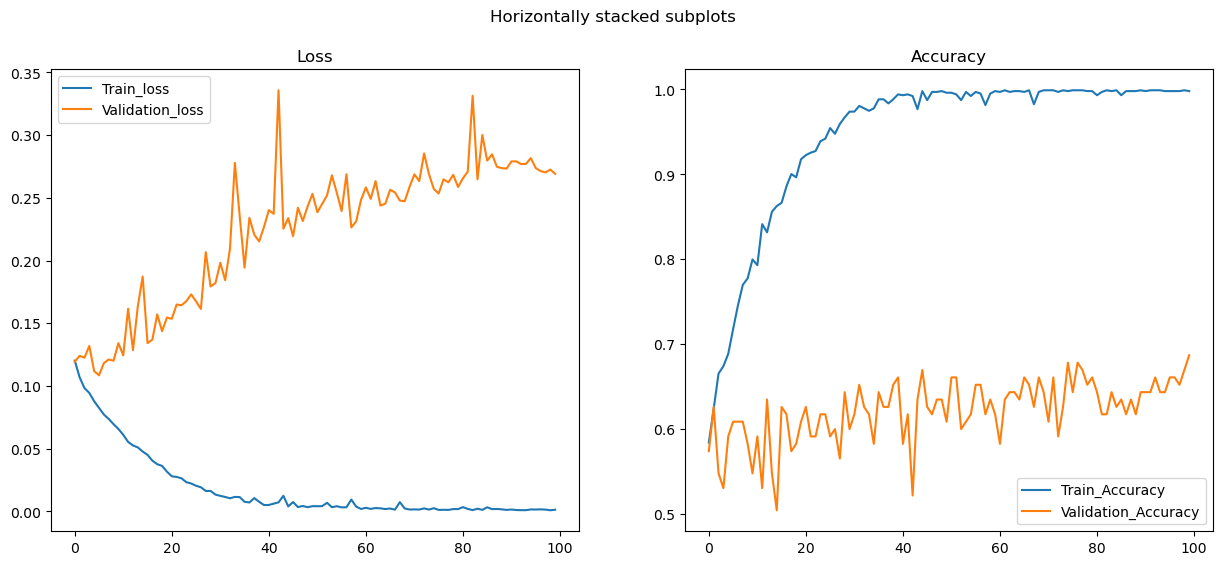

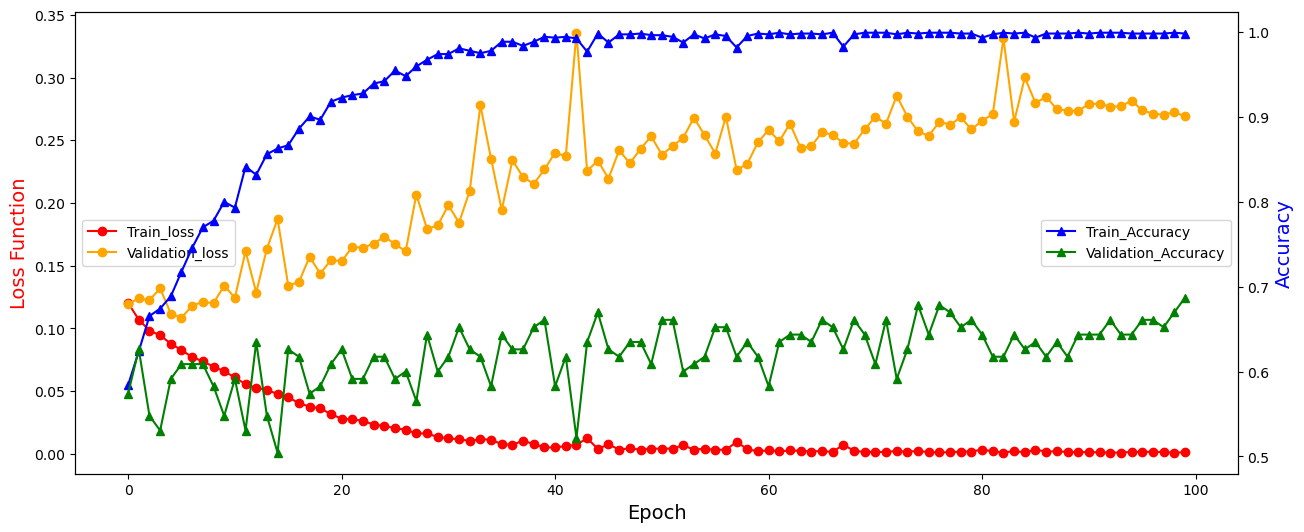

Current time: 38.795 minutes. Time expected till completion: 0.000 minutes
Finished training in: 38.813 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.6869565217391305

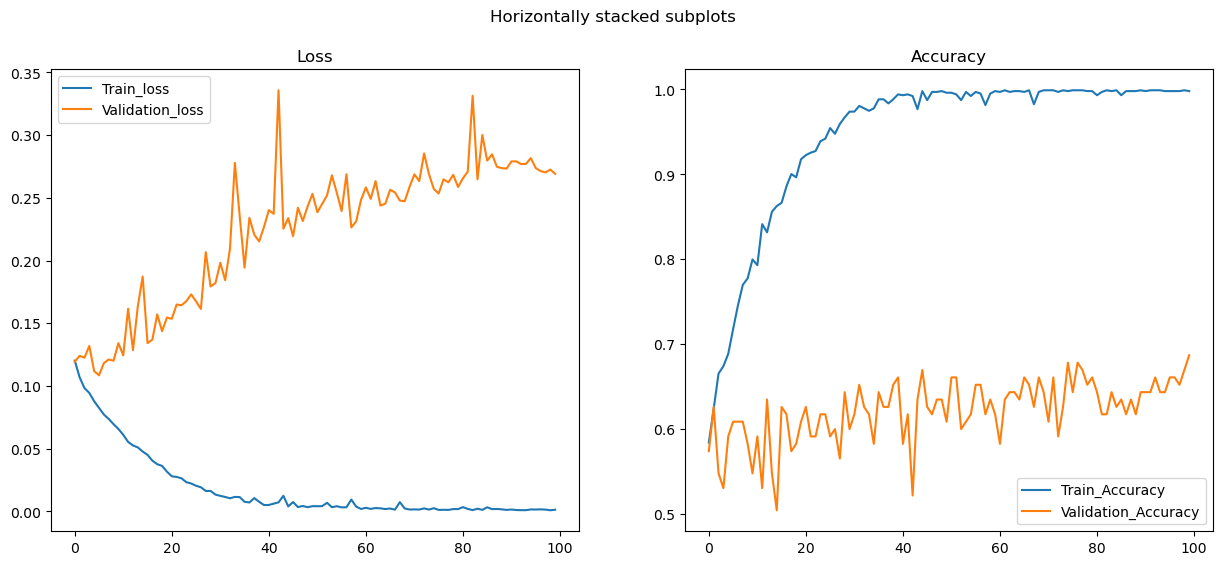

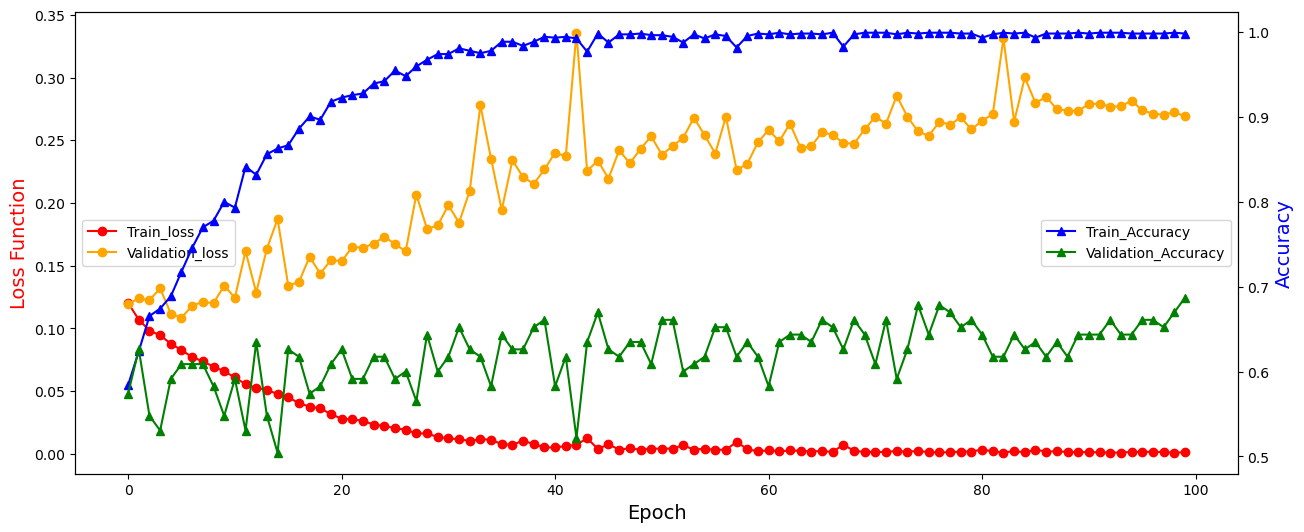

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:11<00:00, 11.15it/s]


Accuracy of the network on the 1034 Train instances: 99.90328820116054%


100%|██████████| 15/15 [00:01<00:00, 10.18it/s]

Accuracy of the network on the 115 Validation instances: 68.69565217391305%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [01:10<00:00,  5.41it/s]


(array([0, 1, 2]), array([162, 168,  50], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGCv2_plus_clas_v01_AlexNet_prediction.csv")

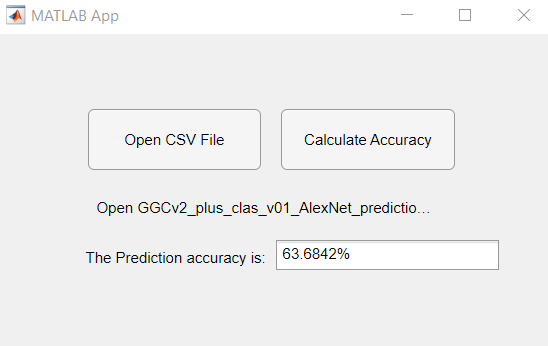

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:12<00:00, 10.29it/s]


Accuracy of the network on the 1034 Train instances: 99.90328820116054%


100%|██████████| 15/15 [00:01<00:00, 13.47it/s]

Accuracy of the network on the 115 Validation instances: 68.69565217391305%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:05<00:00, 74.60it/s]


(array([0, 1, 2]), array([162, 168,  50], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGCv2_plus_clas_v01_AlexNet_best_prediction.csv")

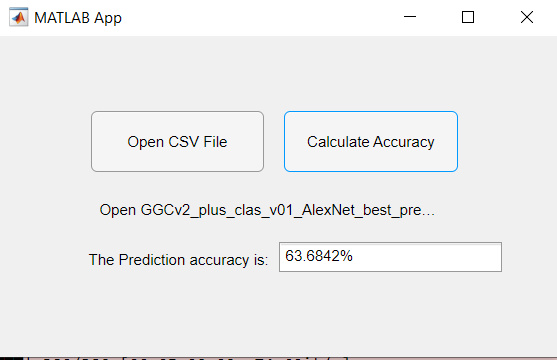